In [1]:
import dicom
import inspect
import pylab
import numpy as np
from glob import glob
import os
import matplotlib
import matplotlib.pyplot as plt
import re
from keras.utils.np_utils import to_categorical

/usr/local/lib/python3.5/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
Using TensorFlow backend.


In [2]:
X = np.load('babyX1.npy')
y = np.load('babyY1.npy')
print(X.shape, y.shape)

(1336, 80, 80) (1336,)


In [3]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [4]:
shuffle = np.random.permutation(np.arange(1336))
X = X[shuffle] ** 0.5
X = (X - np.max(X) / 2) / np.max(X)
X = X.reshape(1336, 80, 80, 1)
y = to_categorical(y[shuffle])

In [5]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(80, 80, 1)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# Note: Keras does automatic shape inference.
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('softmax'))

sgd = SGD(lr=0.3, decay=1e-4, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['precision', 'recall'])

In [6]:
def sym_generator(x, y, batch_num, sym = False):
    b = [i for i, c in enumerate(y) if c[0] == 1]
    m = [i for i, c in enumerate(y) if c[1] == 1]
    while True:
        a = np.random.randint(batch_num) if sym == False else batch_num // 2
        batch_index = np.hstack((np.random.permutation(b)[:a],np.random.permutation(m)[:batch_num - a]))
        yield (x[batch_index], y[batch_index])
        
model.fit_generator(
    sym_generator(X[:1000].reshape(1000,80,80,1), y[:1000], 64), 
    samples_per_epoch=1024, 
    nb_epoch=40,
    validation_data = sym_generator(X[1000:].reshape(336, 80, 80, 1), y[1000:], 128, True),
    nb_val_samples = 128
) 

Epoch 1/40
1024/1024 [==============================] - 18s - loss: 8.8109 - precision: 0.4189 - recall: 0.4189 - val_loss: 8.9701 - val_precision: 0.4435 - val_recall: 0.4435

In [34]:
i = 17
xx = X[i:i+1]

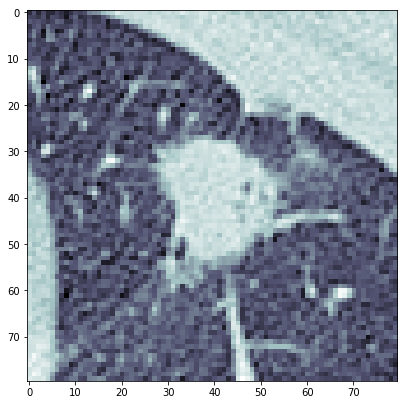

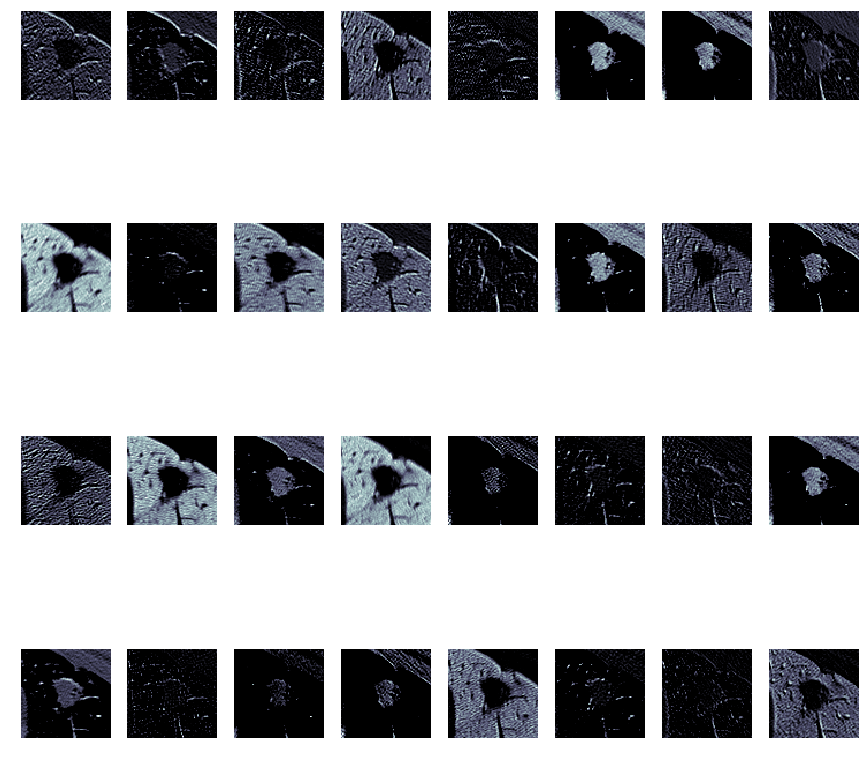

In [35]:
from keras import backend as K

plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
plt.rcParams['image.cmap'] = 'bone'

# with a Sequential model
get1 = K.function([model.layers[0].input],[model.layers[1].output])
intermediate_image = get1([xx])

plt.subplot(2,2, 1)
plt.imshow(xx[0].reshape(80,80))
plt.show()

activations = intermediate_image[0][0]

for i in range(4):
    for j in range(8):
        k = activations[:,:,i * 8 + j]
        plt.subplot(4, 8, i*8 + j + 1)
        plt.imshow(k.reshape((78,78)), plt.cm.bone, extent=[j * 10, j* 10 + 3, j * 10, j * 10 + 3])
        plt.axis('off')
        
plt.show()

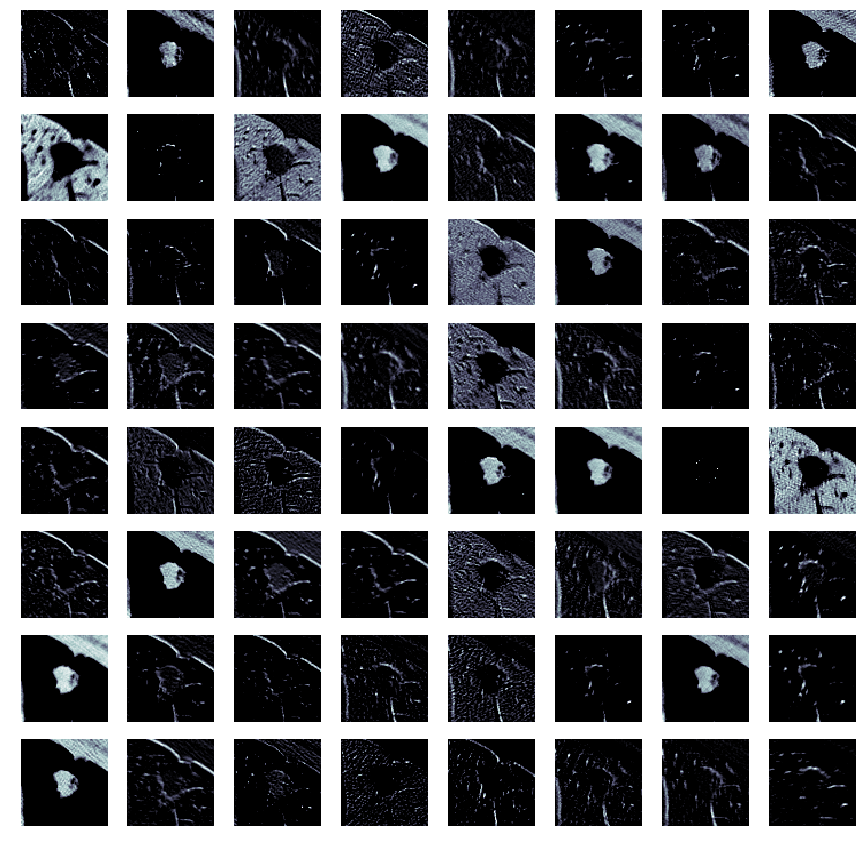

In [36]:
# with a Sequential model
get1 = K.function([model.layers[0].input], [model.layers[3].output])

intermediate_image = get1([xx])

activations = intermediate_image[0][0]

for i in range(8):
    for j in range(8):
        k = activations[:,:,i * 8 + j]
        plt.subplot(8, 8, i*8 + j + 1)
        plt.imshow(k.reshape((76,76)), plt.cm.bone, extent=[j * 10, j* 10 + 3, j * 10, j * 10 + 3])
        plt.axis('off')
        
plt.show()

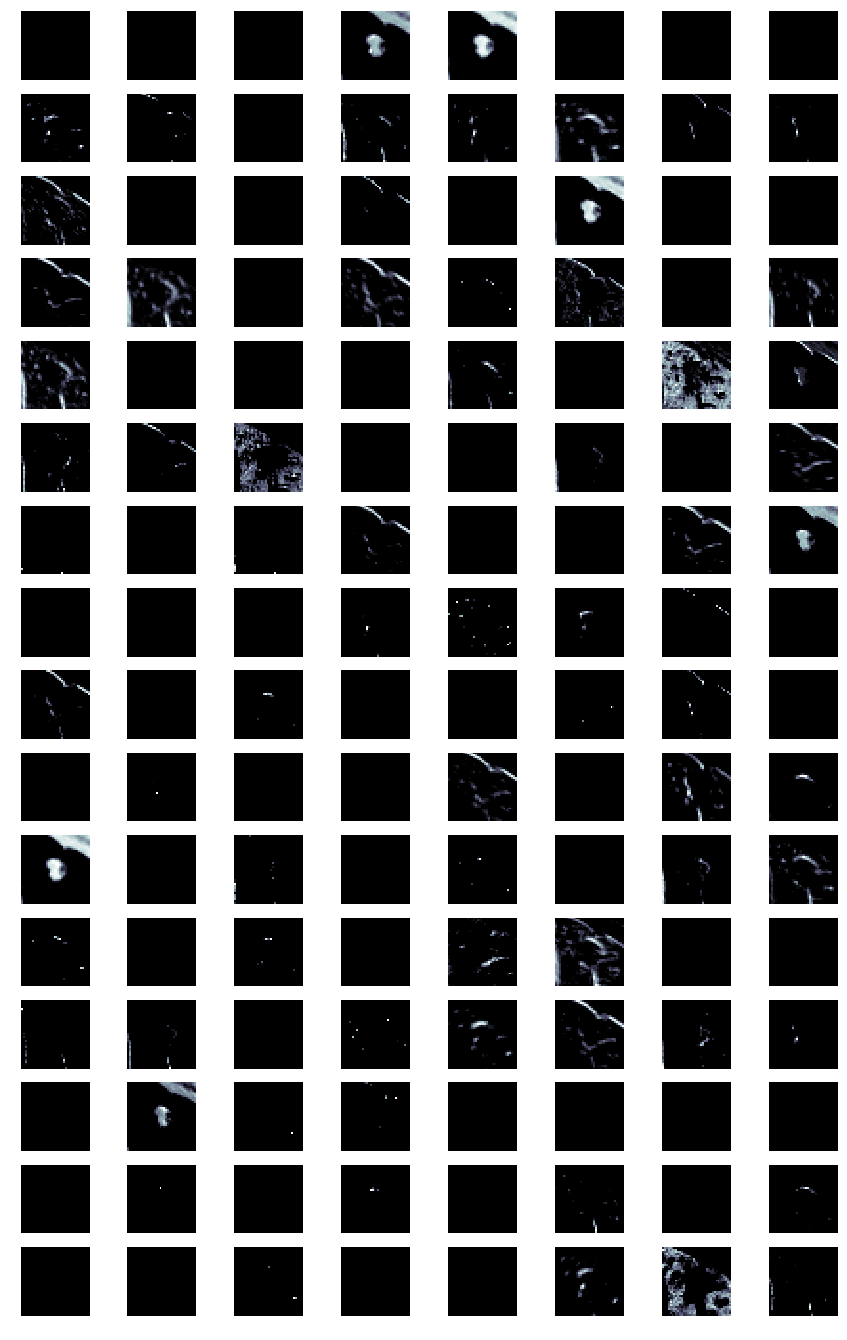

In [41]:
from keras import backend as K

plt.rcParams['figure.figsize'] = (15.0, 24.0) # set default size of plots

# with a Sequential model
get1 = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[7].output])
intermediate_image = get1([xx, 0])

activations = intermediate_image[0][0]

for i in range(16):
    for j in range(8):
        k = activations[:,:,i * 8 + j]
        plt.subplot(16, 8, i*8 + j + 1)
        plt.imshow(k.reshape((36,36)), plt.cm.bone, extent=[j * 10, j* 10 + 3, j * 10, j * 10 + 3])
        plt.axis('off')
        
plt.show()

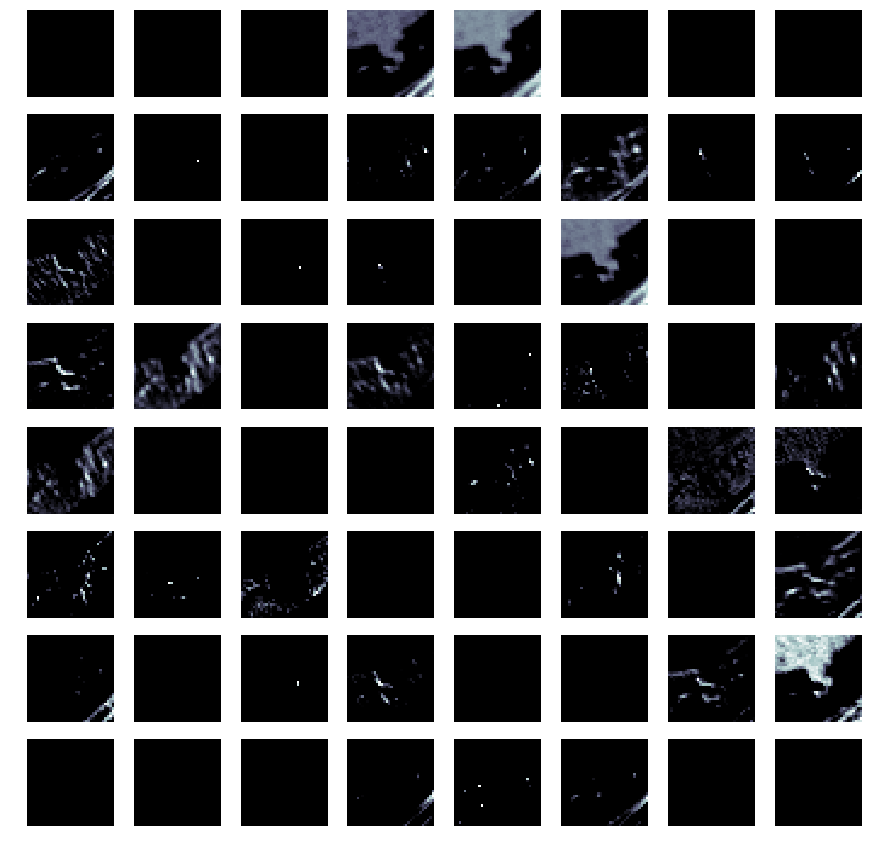

In [29]:
plt.rcParams['figure.figsize'] = (15.0, 50.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'bone'

# with a Sequential model
get1 = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[11].output])
intermediate_image = get1([xx, 0])

activations = intermediate_image[0][0]

for i in range(8):
    for j in range(8):
        k = activations[:,:,i * 8 + j]
        plt.subplot(8, 8, i*8 + j + 1)
        plt.imshow(k.reshape((36,36)), plt.cm.bone)
        plt.axis('off')
        
plt.show()

[[ 0.  1.]]


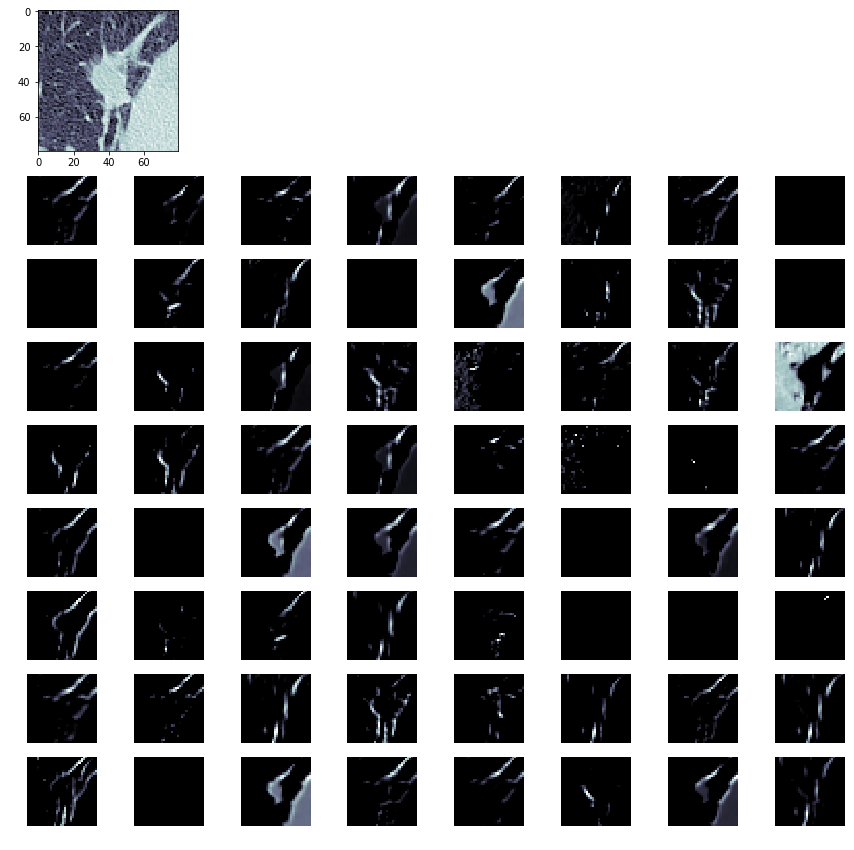

In [75]:
plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'bone'

i = 23

# with a Sequential model
get1 = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[9].output])
intermediate_image = get1([X[i: i+1], 0])

activations = intermediate_image[0][0]

plt.subplot(5,4,1)
plt.imshow(X[i: i+1].reshape(80,80), plt.cm.bone)

print(y[i:i+1])

for i in range(8):
    for j in range(8):
        k = activations[:,:,i * 8 + j]
        plt.subplot(10, 8, 16 + i*8 + j + 1)
        plt.imshow(k.reshape((34,34)), plt.cm.bone)
        plt.axis('off')
        
plt.show()

In [255]:
def evaluate(model):
    e1 = model.evaluate(X[:1000], y[:1000])
    print ('loss: %f\t prec: %f\trecall: %f' % tuple(e1))
    e2 = model.evaluate(X[1000:], y[1000:])
    print ('validation loss: %f\t prec: %f\trecall: %f' % tuple(e2))

In [257]:
evaluate(model)

1000/1000 [==============================] - 3s     

In [258]:
gen = sym_generator(X[1000:].reshape(336, 80, 80, 1), y[1000:], 128, True)

In [274]:
xx, yy = next(gen)
model.evaluate(xx, yy)

124/124 [==============================] - 0s     


[1.2777748780865823, 0.83870968126481582, 0.83870968126481582]

In [1]:
model.predict_classes(np.array([xx[0]]))

NameError: name 'model' is not defined

In [283]:
len(Out[280])

1

## Internal Accuracy

In [285]:
def hot_range_2D(dicom_image: dicom.dataset.FileDataset):
    pixels = dicom_image.pixel_array
    xaxis = np.sum(pixels, axis = 0)
    yaxis = np.sum(pixels, axis = 1)
    xHot = [i for i, v in enumerate(xaxis) if v > 0]
    yHot = [i for i, v in enumerate(yaxis) if v > 0]
    if len(xHot) != 0 and len(yHot) != 0:
        return ((xHot[0], xHot[-1]), (yHot[0], yHot[-1]))

def crop8080(range_2d):
    ((xl, xr), (yu, yd)) = range_2d
    xm = (xl + xr) // 2
    ym = (yu + yd) // 2
    return ((xm - 40, xm + 40), (ym - 40, ym + 40))

isMask = lambda fname : re.search('roimask_\d{4}.dcm', fname) != None

baseDir = 'project1/CCM_Data'

In [11]:
def preprocess(X):
    num = X.shape[0]
    X = X ** 0.5
    X = (X - np.max(X) / 2) / np.max(X)
    X = X.reshape(num, 80, 80, 1)
    return X

4/4 [==============================] - 0s


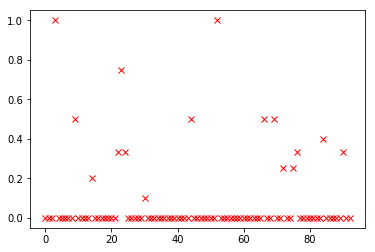

In [12]:
benigns = np.load('benign_cropped.npy')

stats = []
for b in benigns:
    res = model.predict_classes(preprocess(np.array(list(map(lambda slice: slice['roi'], b)))))
    stats.append(res)
    
sss = [s.sum() / len(s) for s in stats]

plt.plot(sss, 'rx')
plt.show()

4/4 [==============================] - 0s


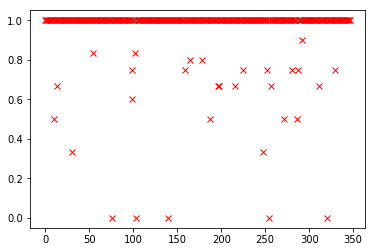

In [13]:
benigns = np.load('malig_cropped.npy')

stats = []
for b in benigns:
    res = model.predict_classes(preprocess(np.array(list(map(lambda slice: slice['roi'], b)))))
    stats.append(res)
    
sss = [s.sum() / len(s) for s in stats]

plt.plot(sss, 'rx')
plt.show()

In [14]:
model.evaluate(X, y)

1336/1336 [==============================] - 4s     

[0.18638839238997887, 0.97529940084069078, 0.97529940084069078]

In [16]:
from keras.preprocessing.image import ImageDataGenerator

In [56]:
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True)

gen = datagen.flow(X, y, batch_size=256)

In [68]:
xx, yy = next(gen)
model.evaluate(xx, yy)

56/56 [==============================] - 0s     


[1.7073227678026472, 0.8214285799435207, 0.8214285799435207]

In [49]:
model.save('model-babystep1-default.h5')

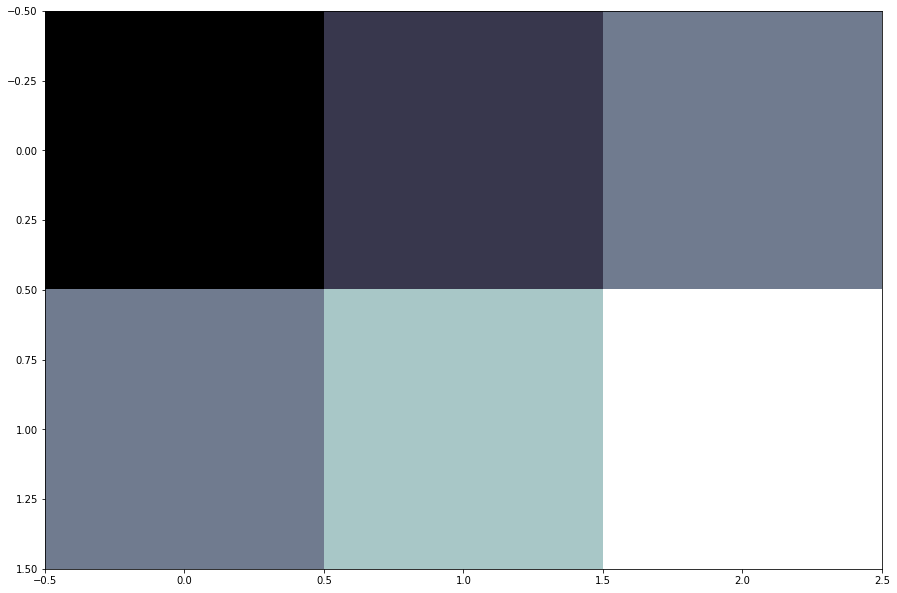

In [27]:
plt.imshow(np.array([[0,1,2],[2,3,4]]), plt.cm.bone)
plt.show()

In [66]:
fcn = model.layers[11]

In [67]:
W = fcn.get_weights()


In [69]:
ws = W[0].reshape(128, 18, 18, 256)
ws.shape

(128, 18, 18, 256)

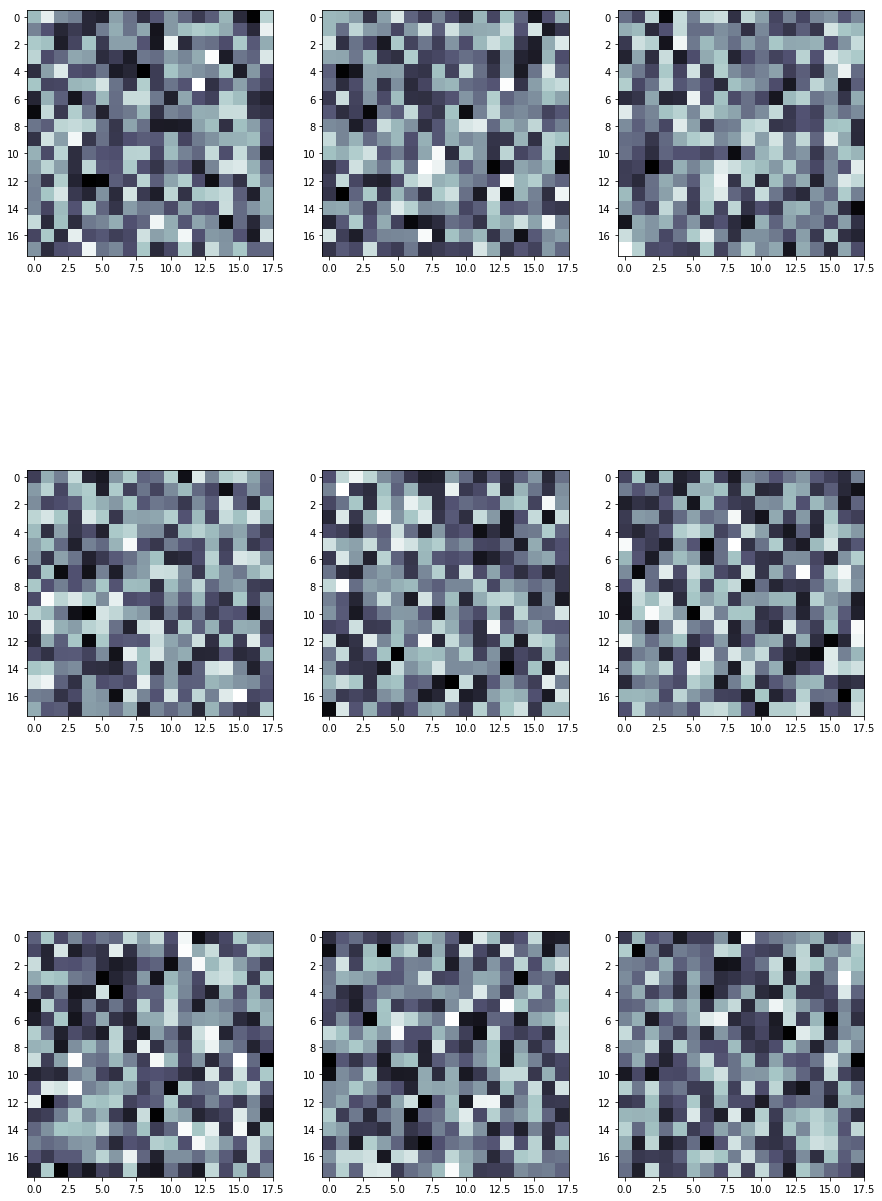

In [74]:
for i in range(9):
    w = (ws[:,:,:,0])[i]
    plt.subplot(3, 3, i+1)
    plt.imshow(w)
plt.show()